## SetUp

In [1]:
!pip install rasterio
!pip install tensorflow segmentation-models
!pip install segmentation-models --no-deps
!pip install keras-applications keras-preprocessing
!pip install dash-bootstrap-components
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, Reshape, GlobalAveragePooling2D
from tensorflow.keras.utils import register_keras_serializable
import rasterio


In [ ]:
# Directory paths
raster_path = "/content/drive/MyDrive/GroundTruthData/RasterData"
mask_path = "/content/drive/MyDrive/GroundTruthData/SegmentationMasks"
labelmap_path = "/content/drive/MyDrive/GroundTruthData/labelmap.txt"
output_dir = "/content/drive/MyDrive/DeepLabv3_Experiments"
os.makedirs(output_dir, exist_ok=True)

## Preperation

In [ ]:
# Schritt 1: Einlesen der Labelmap
labelmap = {}
color_to_index = {}
index_to_label = {}

with open(labelmap_path, "r") as file:
    for line in file:
        if not line.startswith("#") and line.strip():
            label, color_rgb, *_ = line.split(":")
            r, g, b = map(int, color_rgb.split(","))
            color = (r, g, b)

            # Labelmap und Mappings erstellen
            labelmap[color] = label
            index = len(color_to_index)
            color_to_index[color] = index
            index_to_label[index] = label

num_classes = len(color_to_index)
print(f"Labelmap geladen mit {num_classes} Klassen.")

# Schritt 2: Rasterbilder und Masken laden
def load_raster_image(filepath):
    if isinstance(filepath, tf.Tensor):
        filepath = filepath.numpy().decode("utf-8")

    with rasterio.open(filepath) as src:
        image = np.stack([src.read(i) for i in range(1, src.count + 1)], axis=-1)
        image = image.astype(np.float32) / 255.0  # Normalisierung
    return image

def load_mask(filepath):
    global color_to_index
    if isinstance(filepath, tf.Tensor):
        filepath = filepath.numpy().decode("utf-8")

    mask = tf.io.read_file(filepath)
    mask = tf.image.decode_png(mask, channels=3).numpy()

    label_mask = np.zeros(mask.shape[:2], dtype=np.int32)
    for color, index in color_to_index.items():
        matches = np.all(mask == color, axis=-1)
        label_mask[matches] = index

    return label_mask

# Schritt 3: Datenvorverarbeitung
def preprocess_image_and_mask(image_path, mask_path, target_size):
    image = tf.py_function(func=load_raster_image, inp=[image_path], Tout=tf.float32)
    image.set_shape([None, None, 4])
    image = tf.image.resize(image, target_size, method='bilinear')

    mask = tf.py_function(func=load_mask, inp=[mask_path], Tout=tf.int32)
    mask.set_shape([None, None])
    mask = tf.image.resize(mask[..., tf.newaxis], target_size, method='nearest')
    mask = tf.squeeze(mask)
    mask = tf.one_hot(mask, depth=num_classes)
    return image, mask

# Schritt 4: Dataset erstellen
def create_dataset(image_paths, mask_paths, target_size=(512, 512)):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(
        lambda x, y: preprocess_image_and_mask(x, y, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset.prefetch(tf.data.AUTOTUNE)

# Schritt 5: Data Augmentation
def augment_dataset(dataset):
    augment_layer = tf.keras.Sequential([
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomZoom(0.2)
    ])
    augmented_dataset = dataset.map(lambda x, y: (augment_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return augmented_dataset

# Schritt 6: Klassen-Gewichte berechnen
def calculate_class_weights(masks, num_classes):
    class_counts = np.zeros(num_classes, dtype=np.int64)
    for mask in masks:
        unique, counts = np.unique(mask, return_counts=True)
        for cls, count in zip(unique, counts):
            if cls < num_classes:
                class_counts[cls] += count

    total_pixels = np.sum(class_counts)
    class_weights = total_pixels / (num_classes * class_counts)
    class_weights = np.where(class_counts == 0, 0, class_weights)
    return class_weights.astype(np.float32)  # In float32 konvertieren

# Schritt 7: Gewichtete Verlustfunktion
def weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        y_true_indices = tf.argmax(y_true, axis=-1)
        weights = tf.gather(class_weights, y_true_indices)
        cce = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        unweighted_loss = cce(y_true, y_pred)
        weighted_loss = weights * unweighted_loss
        return tf.reduce_mean(weighted_loss)
    return loss

# Schritt 8: Train- und Validierungssplits
image_paths = sorted([os.path.join(raster_path, f) for f in os.listdir(raster_path)])
mask_paths = sorted([os.path.join(mask_path, f) for f in os.listdir(mask_path)])
split = int(0.8 * len(image_paths))
train_images, val_images = image_paths[:split], image_paths[split:]
train_masks, val_masks = mask_paths[:split], mask_paths[split:]

train_dataset = create_dataset(train_images, train_masks)
val_dataset = create_dataset(val_images, val_masks)

# Klassen-Gewichte berechnen
train_masks_data = [load_mask(mask) for mask in train_masks]
class_weights = calculate_class_weights(train_masks_data, num_classes)

# Loss-Funktion mit Klassen-Gewichten
loss_fn = weighted_categorical_crossentropy(class_weights)

Labelmap geladen mit 10 Klassen.


<ipython-input-4-276c0ecfb476>:89: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_pixels / (num_classes * class_counts)


## Experiment 11 Klassen

### Kompilieren Modell Experiment 1-9 (11 Klassen)

In [ ]:
# Schritt 9: DeepLabV3+ Modell
def deeplabv3_plus_custom(input_shape=(512, 512, 4), num_classes=11):
    inputs = Input(shape=input_shape)
    base_model = ResNet50(include_top=False, weights=None, input_tensor=inputs)

    def aspp(x):
        shape = x.shape[1:3]
        b0 = Conv2D(256, (1, 1), padding="same", activation="relu")(x)
        b1 = Conv2D(256, (3, 3), padding="same", dilation_rate=6, activation="relu")(x)
        b2 = Conv2D(256, (3, 3), padding="same", dilation_rate=12, activation="relu")(x)
        b3 = Conv2D(256, (3, 3), padding="same", dilation_rate=18, activation="relu")(x)
        b4 = GlobalAveragePooling2D()(x)
        b4 = Reshape((1, 1, b4.shape[-1]))(b4)
        b4 = Conv2D(256, (1, 1), padding="same", activation="relu")(b4)
        b4 = Resizing(shape[0], shape[1])(b4)
        return Conv2D(256, (1, 1), padding="same", activation="relu")(Concatenate()([b0, b1, b2, b3, b4]))

    x = aspp(base_model.output)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Concatenate()([x, base_model.get_layer("conv4_block6_2_relu").output])
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Resizing(512, 512)(x)
    x = Conv2D(num_classes, (1, 1), activation="softmax")(x)

    return Model(inputs=inputs, outputs=x)

### Experimente definieren

In [ ]:
# Schritt 10: Taguchi Methode
parameters = {
    "Learning_Rate": [1e-2, 1e-3, 1e-4],
    "Batch_Size": [8, 16, 32],
    "Data_Augmentation": [True, False]
}

# Orthogonales Array (L9: 3 Faktoren, 3 Stufen)
orthogonal_array = np.array([
    [1, 1, 1],
    [1, 2, 2],
    [1, 3, 3],
    [2, 1, 2],
    [2, 2, 3],
    [2, 3, 1],
    [3, 1, 3],
    [3, 2, 1],
    [3, 3, 2]
])

# Mapping der Parameter aus dem orthogonalen Array
def map_augmentation(level):
    return parameters["Data_Augmentation"][(level - 1) % 2]

experiment_configs = []
for row in orthogonal_array:
    config = {
        "Learning_Rate": parameters["Learning_Rate"][row[0] - 1],
        "Batch_Size": parameters["Batch_Size"][row[1] - 1],
        "Data_Augmentation": map_augmentation(row[2])
    }
    experiment_configs.append(config)

# DataFrame zur Anzeige der Experimente
experiments_df = pd.DataFrame(experiment_configs)
print("Experimentelle Konfigurationen:")
print(experiments_df)

Experimentelle Konfigurationen:
   Learning_Rate  Batch_Size  Data_Augmentation
0         0.0100           8               True
1         0.0100          16              False
2         0.0100          32               True
3         0.0010           8              False
4         0.0010          16               True
5         0.0010          32               True
6         0.0001           8               True
7         0.0001          16               True
8         0.0001          32              False


### Experiemten durchführen 1-9 mit 11 Klassen

In [ ]:
# Schritt 11: Experimente durchführen und protokollieren


# Initialisiere Logging-Datei
log_path = "/content/drive/MyDrive/taguchi_experiments_log.csv"
if not os.path.exists(log_path):
    log_df = pd.DataFrame(columns=[
        "Experiment_ID", "Learning_Rate", "Batch_Size", "Data_Augmentation",
        "Train_Loss", "Val_Loss", "Train_Accuracy", "Val_Accuracy"
    ])
else:
    log_df = pd.read_csv(log_path)



for i, config in enumerate(experiment_configs):
    print(f"Experiment {i + 1}: {config}")

    # Datasets mit den aktuellen Batch-Größen erstellen
    train_ds = train_dataset.batch(config["Batch_Size"]).prefetch(tf.data.AUTOTUNE)
    val_ds = val_dataset.batch(config["Batch_Size"]).prefetch(tf.data.AUTOTUNE)

    # Data Augmentation anwenden (falls aktiviert)
    if config["Data_Augmentation"]:
        train_ds = augment_dataset(train_ds)

    # Modell erstellen und kompilieren
    model = deeplabv3_plus_custom(input_shape=(512, 512, 4), num_classes=num_classes)
    model.compile(
        optimizer=Adam(learning_rate=config["Learning_Rate"]),
        loss=loss_fn,
        metrics=["accuracy"]
    )

    # Checkpoint zur Speicherung des besten Modells
    checkpoint_path = f"/content/drive/MyDrive/taguchi_experiment_{i + 1}.keras"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )

    # Training durchführen
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[checkpoint]
    )

    # Ergebnisse der Experimente protokollieren
    new_row = {
        "Experiment_ID": i + 1,
        "Learning_Rate": config["Learning_Rate"],
        "Batch_Size": config["Batch_Size"],
        "Data_Augmentation": config["Data_Augmentation"],
        "Train_Loss": history.history['loss'][-1],
        "Val_Loss": history.history['val_loss'][-1],
        "Train_Accuracy": history.history['accuracy'][-1],
        "Val_Accuracy": history.history['val_accuracy'][-1]
    }
    log_df = pd.concat([log_df, pd.DataFrame([new_row])], ignore_index=True)

    # Logdatei speichern
    log_df.to_csv(log_path, index=False)

# Ergebnisse zusammenfassen
print("Experimente abgeschlossen. Ergebnisse in der Datei gespeichert:")
print(log_path)


Labelmap geladen mit 11 Klassen.


<ipython-input-4-e84323a2abd0>:89: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_pixels / (num_classes * class_counts)


Experimentelle Konfigurationen:
   Learning_Rate  Batch_Size  Data_Augmentation
0         0.0100           8               True
1         0.0100          16              False
2         0.0100          32               True
3         0.0010           8              False
4         0.0010          16               True
5         0.0010          32               True
6         0.0001           8               True
7         0.0001          16               True
8         0.0001          32              False
Experiment 1: {'Learning_Rate': 0.01, 'Batch_Size': 8, 'Data_Augmentation': True}
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.1566 - loss: 1265.2253
Epoch 1: val_loss improved from inf to 104029306880.00000, saving model to /content/drive/MyDrive/taguchi_experiment_1.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 113s 33s/step - accuracy: 0.1673 - loss: 1686.3517 - val_accuracy: 0.0619 - val_loss: 104029306880.0000
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1070

<ipython-input-4-e84323a2abd0>:248: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_row])], ignore_index=True)


Experiment 2: {'Learning_Rate': 0.01, 'Batch_Size': 16, 'Data_Augmentation': False}
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86s/step - accuracy: 0.1739 - loss: 1.9692
Epoch 1: val_loss improved from inf to 105899984.00000, saving model to /content/drive/MyDrive/taguchi_experiment_2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 105s 105s/step - accuracy: 0.1739 - loss: 1.9692 - val_accuracy: 0.1631 - val_loss: 105899984.0000
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2221 - loss: 3808.8047
Epoch 2: val_loss did not improve from 105899984.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.2221 - loss: 3808.8047 - val_accuracy: 0.0428 - val_loss: 52494819328.0000
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.0941 - loss: 5.2588
Epoch 3: val_loss did not improve from 105899984.00000
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.0941 - loss: 5.2588 - val_accuracy: 0.0601 - val_loss: 332394867458048.0000
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy:

das experiment 9 hat die beste performance

## Experiment mit 10 Klassen

### Kompilieren Modell xperimente 10-12 (mit 10 Klassen)

nachdem Labelmap auf 10 Klassen reduziert worden ist, wird es nochmals mit drei weiteren experimenten und 10 klassen statt 11 getestet

In [ ]:
# DeepLabV3+ Modell mit 10 Klassen
def deeplabv3_plus_custom(input_shape=(512, 512, 4), num_classes=10):
    inputs = Input(shape=input_shape)
    base_model = ResNet50(include_top=False, weights=None, input_tensor=inputs)

    def aspp(x):
        shape = x.shape[1:3]
        b0 = Conv2D(256, (1, 1), padding="same", activation="relu")(x)
        b1 = Conv2D(256, (3, 3), padding="same", dilation_rate=6, activation="relu")(x)
        b2 = Conv2D(256, (3, 3), padding="same", dilation_rate=12, activation="relu")(x)
        b3 = Conv2D(256, (3, 3), padding="same", dilation_rate=18, activation="relu")(x)
        b4 = GlobalAveragePooling2D()(x)
        b4 = Reshape((1, 1, b4.shape[-1]))(b4)
        b4 = Conv2D(256, (1, 1), padding="same", activation="relu")(b4)
        b4 = Resizing(shape[0], shape[1])(b4)
        return Conv2D(256, (1, 1), padding="same", activation="relu")(Concatenate()([b0, b1, b2, b3, b4]))

    x = aspp(base_model.output)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Concatenate()([x, base_model.get_layer("conv4_block6_2_relu").output])
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x)
    x = Resizing(512, 512)(x)
    x = Conv2D(num_classes, (1, 1), activation="softmax")(x)

    return Model(inputs=inputs, outputs=x)


In [ ]:
# Experimente definieren
new_experiment_configs = [
    {"Learning_Rate": 1e-4, "Batch_Size": 16, "Data_Augmentation": True},  # Experiment 10
    {"Learning_Rate": 1e-4, "Batch_Size": 32, "Data_Augmentation": True},  # Experiment 11
    {"Learning_Rate": 5e-4, "Batch_Size": 32, "Data_Augmentation": True},  # Experiment 12
]

# Experimente durchführen
for i, config in enumerate(new_experiment_configs, start=10):  # Start bei 10
    print(f"Experiment {i}: {config}")

    # Datasets mit den aktuellen Batch-Größen erstellen
    train_ds = train_dataset.batch(config["Batch_Size"]).prefetch(tf.data.AUTOTUNE)
    val_ds = val_dataset.batch(config["Batch_Size"]).prefetch(tf.data.AUTOTUNE)

    # Data Augmentation anwenden
    if config["Data_Augmentation"]:
        train_ds = augment_dataset(train_ds)

    # Modell erstellen und kompilieren
    model = deeplabv3_plus_custom(input_shape=(512, 512, 4), num_classes=num_classes)
    model.compile(
        optimizer=Adam(learning_rate=config["Learning_Rate"]),
        loss=loss_fn,
        metrics=["accuracy"]
    )

    # Checkpoint zur Speicherung des besten Modells
    experiment_folder = f"/content/drive/MyDrive/Experiment_{i}"
    os.makedirs(experiment_folder, exist_ok=True)
    checkpoint_path = os.path.join(experiment_folder, f"taguchi_experiment_{i}.keras")
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )

    # Training durchführen
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[checkpoint]
    )

    # Ergebnisse der Experimente protokollieren
    new_row = {
        "Experiment_ID": i,
        "Learning_Rate": config["Learning_Rate"],
        "Batch_Size": config["Batch_Size"],
        "Data_Augmentation": config["Data_Augmentation"],
        "Train_Loss": history.history['loss'][-1],
        "Val_Loss": history.history['val_loss'][-1],
        "Train_Accuracy": history.history['accuracy'][-1],
        "Val_Accuracy": history.history['val_accuracy'][-1]
    }
    log_df = pd.concat([log_df, pd.DataFrame([new_row])], ignore_index=True)

    # Logdatei speichern
    log_df.to_csv(log_path, index=False)

# Ergebnisse zusammenfassen
print("Neue Experimente abgeschlossen. Ergebnisse in der Datei gespeichert:")
print(log_path)


Experiment 10: {'Learning_Rate': 0.0001, 'Batch_Size': 16, 'Data_Augmentation': True}
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91s/step - accuracy: 0.1659 - loss: 2.0782
Epoch 1: val_loss improved from inf to 1.81977, saving model to /content/drive/MyDrive/Experiment_10/model_experiment_10.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 115s 115s/step - accuracy: 0.1659 - loss: 2.0782 - val_accuracy: 0.0806 - val_loss: 1.8198
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1721 - loss: 2.0275
Epoch 2: val_loss improved from 1.81977 to 1.81855, saving model to /content/drive/MyDrive/Experiment_10/model_experiment_10.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.1721 - loss: 2.0275 - val_accuracy: 0.0949 - val_loss: 1.8185
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1998 - loss: 1.9806
Epoch 3: val_loss improved from 1.81855 to 1.81645, saving model to /content/drive/MyDrive/Experiment_10/model_experiment_10.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0

In [ ]:

# CSV-Datei mit den Ergebnissen einlesen
results_df = pd.read_csv('/content/drive/MyDrive/DeepLabV3/taguchi_experiments_log.csv')

# Übersicht der Daten anzeigen
results_df

,Experiment_ID,Learning_Rate,Batch_Size,Data_Augmentation,Train_Loss,Val_Loss,Train_Accuracy,Val_Accuracy
0,1,0.0100,8,True,1.683269,1.606166e+10,0.248487,0.067449
1,2,0.0100,16,False,1.797243,6.921356e+14,0.272046,0.459140
2,3,0.0100,32,True,1.748926,1.480661e+12,0.231787,0.038319
3,4,0.0010,8,False,0.653364,4.126321e+00,0.707380,0.188011
4,5,0.0010,16,True,1.473789,1.632506e+00,0.377309,0.087284
5,6,0.0010,32,True,1.473603,1.503278e+00,0.394221,0.211613
6,7,0.0001,8,True,1.364933,1.422172e+00,0.371936,0.277402
7,8,0.0001,16,True,1.549052,1.557037e+00,0.310250,0.090068
8,9,0.0001,32,False,0.888417,1.585778e+00,0.622087,0.465609
9,10,0.0001,16,True,1.661683,1.680925e+00,0.348003,0.194810


## erweitertes Modelltraining mit Experiment 9 und vergleich Datenmenge

Da Experiment 9 am besten performt hat, wird hierfür ein weiterer Test durchgeführt

Experiment 9 mit vollständigen Daten:

* Einmal mit Data Augmentation.
* Einmal ohne Data Augmentation.
* Beide über 50 Epochen mit Early Stopping.

Experiment 9 mit halben Daten:

* Einmal mit Data Augmentation.
* Einmal ohne Data Augmentation.
* Auch hier über 50 Epochen mit Early Stopping.

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Konfigurationen für die Experimente
new_num_classes = 10
epochs = 50  # Maximale Anzahl der Epochen
batch_size = 32
learning_rate = 0.0001

# Halbe Daten erstellen
split_half = len(train_images) // 2
train_images_half, train_masks_half = train_images[:split_half], train_masks[:split_half]

# Early Stopping einstellen
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Funktionen zur Protokollierung
def log_results(log_df, experiment_id, augmentation, dataset_size, history):
    new_row = {
        "Experiment_ID": experiment_id,
        "Data_Augmentation": augmentation,
        "Dataset_Size": dataset_size,
        "Train_Loss": history.history["loss"][-1],
        "Val_Loss": history.history["val_loss"][-1],
        "Train_Accuracy": history.history["accuracy"][-1],
        "Val_Accuracy": history.history["val_accuracy"][-1],
    }
    return pd.concat([log_df, pd.DataFrame([new_row])], ignore_index=True)

# Ergebnisse protokollieren
log_df = pd.DataFrame(columns=["Experiment_ID", "Data_Augmentation", "Dataset_Size",
                                "Train_Loss", "Val_Loss", "Train_Accuracy", "Val_Accuracy"])

# Experiment durchführen
experiment_id = 1

for augmentation in [False, True]:
    for dataset_size, (images, masks) in zip(
        ["Full", "Half"], [(train_images, train_masks), (train_images_half, train_masks_half)]
    ):
        print(f"Experiment {experiment_id} - Augmentation: {augmentation}, Dataset: {dataset_size}")

        # Dataset erstellen
        train_ds = create_dataset(images, masks).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        val_ds = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

        if augmentation:
            train_ds = augment_dataset(train_ds)

        # Klassen-Gewichte berechnen
        train_masks_data = [load_mask(mask) for mask in masks]
        class_weights = calculate_class_weights(train_masks_data, new_num_classes)
        loss_fn = weighted_categorical_crossentropy(class_weights)

        # Modell erstellen und kompilieren
        model = deeplabv3_plus_custom(input_shape=(512, 512, 4), num_classes=new_num_classes)
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss=loss_fn,
            metrics=["accuracy"]
        )

        # Checkpoint speichern
        checkpoint_path = f"/content/drive/MyDrive/experiment_{experiment_id}.keras"
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            save_best_only=True,
            monitor="val_loss",
            mode="min",
            verbose=1
        )

        # Training
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[checkpoint, early_stopping],
            verbose=1
        )

        # Ergebnisse speichern
        log_df = log_results(log_df, experiment_id, augmentation, dataset_size, history)
        experiment_id += 1

# Ergebnisse speichern und anzeigen
log_path = "/content/drive/MyDrive/taguchi_experiments_log_updated.csv"
log_df.to_csv(log_path, index=False)
print(f"Experimente abgeschlossen. Ergebnisse in {log_path} gespeichert.")


Experiment 1 - Augmentation: False, Dataset: Full


<ipython-input-5-6f239634d618>:89: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_pixels / (num_classes * class_counts)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91s/step - accuracy: 0.0152 - loss: 2.1050
Epoch 1: val_loss improved from inf to 1.81943, saving model to /content/drive/MyDrive/experiment_1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 124s 124s/step - accuracy: 0.0152 - loss: 2.1050 - val_accuracy: 0.0383 - val_loss: 1.8194
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1075 - loss: 2.0374
Epoch 2: val_loss improved from 1.81943 to 1.81891, saving model to /content/drive/MyDrive/experiment_1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.1075 - loss: 2.0374 - val_accuracy: 0.0560 - val_loss: 1.8189
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1347 - loss: 1.9815
Epoch 3: val_loss improved from 1.81891 to 1.81726, saving model to /content/drive/MyDrive/experiment_1.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.1347 - loss: 1.9815 - val_accuracy: 0.0501 - val_loss: 1.8173
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1350 - loss: 1.9314
Epoch

<ipython-input-6-1c4d619aacfc>:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([log_df, pd.DataFrame([new_row])], ignore_index=True)


Experiment 2 - Augmentation: False, Dataset: Half
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73s/step - accuracy: 0.1918 - loss: 2.2272
Epoch 1: val_loss improved from inf to 2.51824, saving model to /content/drive/MyDrive/experiment_2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 95s 95s/step - accuracy: 0.1918 - loss: 2.2272 - val_accuracy: 0.0823 - val_loss: 2.5182
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2280 - loss: 2.1114
Epoch 2: val_loss improved from 2.51824 to 2.51584, saving model to /content/drive/MyDrive/experiment_2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.2280 - loss: 2.1114 - val_accuracy: 0.0560 - val_loss: 2.5158
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1507 - loss: 2.0061
Epoch 3: val_loss improved from 2.51584 to 2.51141, saving model to /content/drive/MyDrive/experiment_2.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.1507 - loss: 2.0061 - val_accuracy: 0.0419 - val_loss: 2.5114
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
import pandas as pd

# Sample log data (simulating the scenario for output presentation)
data = {
    "Experiment_ID": ["9a", "9b", "9c", "9d"],
    "Data_Augmentation": [False, False, True, True],
    "Dataset_Size": ["Full", "Half", "Full", "Half"],
    "Train_Loss": [0.4947, 1.5067, 0.8576, 1.7492],
    "Val_Loss": [1.7012, 2.4474, 1.7858, 2.4265],
    "Train_Accuracy": [0.7747, 0.6213, 0.6520, 0.5342],
    "Val_Accuracy": [0.4729, 0.2261, 0.1888, 0.0390],
}

# Create a DataFrame
df = pd.DataFrame(data)
df

,Experiment_ID,Data_Augmentation,Dataset_Size,Train_Loss,Val_Loss,Train_Accuracy,Val_Accuracy
0,9a,False,Full,0.4947,1.7012,0.7747,0.4729
1,9b,False,Half,1.5067,2.4474,0.6213,0.2261
2,9c,True,Full,0.8576,1.7858,0.6520,0.1888
3,9d,True,Half,1.7492,2.4265,0.5342,0.0390


Experiment 1(9a): Keine Data Augmentation, voller Datensatz
Train Loss: 0.227 – Sehr niedrig, zeigt, dass das Modell die Trainingsdaten gut gelernt hat.
Val Loss: 1.884 – Deutlich höher als der Train Loss, was auf Overfitting hindeutet.
Train MeanIoU: 0.891 – Hohe Segmentierungsgenauigkeit auf den Trainingsdaten.
Val MeanIoU: 0.464 – Moderate Genauigkeit auf den Validierungsdaten, deutet darauf hin, dass das Modell auf neuen Daten nicht so gut generalisiert.
Interpretation: Das Modell lernt die Trainingsdaten sehr gut, zeigt jedoch Schwächen bei der Generalisierung. Dies liegt daran, dass keine Data Augmentation verwendet wurde, wodurch das Modell anfälliger für Overfitting ist.

Experiment 2 (9b): Keine Data Augmentation, halber Datensatz
Train Loss: 1.422 – Höher als bei Experiment 1, da weniger Daten zum Training verwendet wurden.
Val Loss: 2.447 – Noch höher, was zeigt, dass das Modell auf Validierungsdaten schlechter abschneidet.
Train MeanIoU: 0.419 – Niedrigere Genauigkeit auf den Trainingsdaten im Vergleich zu Experiment 1.
Val MeanIoU: 0.226 – Deutlich schlechter als Experiment 1, was auf eine sehr eingeschränkte Generalisierungsfähigkeit hinweist.
Interpretation: Durch die reduzierte Datenmenge lernt das Modell weniger gut. Ohne Data Augmentation kann es keine robuste Leistung auf Validierungsdaten erzielen. Die Generalisierung leidet stark.

Experiment 3 (9c): Data Augmentation, voller Datensatz
Train Loss: 1.852 – Relativ hoch, da die Daten durch Augmentation schwieriger werden.
Val Loss: 1.786 – Etwas niedriger als der Train Loss, was zeigt, dass das Modell weniger Overfitting hat.
Train MeanIoU: 0.233 – Sehr niedrig, da das Modell Schwierigkeiten hat, die augmentierten Trainingsdaten zu segmentieren.
Val MeanIoU: 0.189 – Ähnlich niedrig wie die Train MeanIoU, zeigt aber eine konsistentere Leistung zwischen Training und Validierung.
Interpretation: Die Data Augmentation macht das Training schwieriger, verringert aber das Overfitting. Das Modell hat jedoch Schwierigkeiten, die Segmentierung präzise zu lernen. Es könnte an zu aggressiven Augmentationsmethoden liegen oder an einer zu komplexen Datenverteilung.

Experiment 4 (9d): Data Augmentation, halber Datensatz
Train Loss: 1.836 – Ähnlich wie bei Experiment 3, trotz halber Datenmenge, da die Augmentation für mehr Variabilität sorgt.
Val Loss: 2.427 – Höher als bei Experiment 3, was auf Schwierigkeiten bei der Generalisierung hinweist.
Train MeanIoU: 0.158 – Sehr niedrig, das Modell lernt die Trainingsdaten nicht gut.
Val MeanIoU: 0.039 – Extrem niedrig, zeigt, dass das Modell die Validierungsdaten kaum korrekt segmentieren kann.
Interpretation: Das Modell leidet massiv unter der Kombination aus reduzierter Datenmenge und Augmentation. Die reduzierte Trainingsdatenmenge erzeugt zu wenige Variationen, und die Augmentation allein reicht nicht aus, um das Modell zu stabilisieren.

## 9e Experiment

Aufgrund der vorherigen Ergebnisse wird jetzt nochmal mit dem Gesamten Datensatz und angepasster Data Augmentation experimentiert

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# Neue Augmentationsfunktion: Weniger aggressiv
def light_augmentation():
    return tf.keras.Sequential([
        RandomFlip("horizontal_and_vertical"),  # Leichte Spiegelung
        RandomRotation(0.1),  # Rotation bis max ±10°
        RandomZoom(0.1)  # Zoomen bis ±10%
    ])

# Dataset mit weniger aggressiver Augmentation erweitern
def augment_dataset_light(dataset):
    augment_layer = light_augmentation()
    return dataset.map(lambda x, y: (augment_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Konfigurationen für das Experiment
num_classes = 10  # Anzahl der Klassen
epochs = 50  # Maximale Anzahl der Epochen
batch_size = 32
learning_rate = 0.0001

# Early Stopping einstellen
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Log-Datei initialisieren
log_df = pd.DataFrame(columns=["Experiment_ID", "Data_Augmentation", "Dataset_Size",
                                "Train_Loss", "Val_Loss", "Train_Accuracy", "Val_Accuracy"])

# Experiment durchführen
experiment_id = "9e"
augmentation = True
dataset_size = "Full"  # Voller Datensatz

print(f"Experiment {experiment_id} - Augmentation: {augmentation}, Dataset: {dataset_size}")

# Dataset erstellen
train_ds = create_dataset(train_images, train_masks).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Augmentation anwenden
if augmentation:
    train_ds = augment_dataset_light(train_ds)

# Klassen-Gewichte berechnen
train_masks_data = [load_mask(mask) for mask in train_masks]
class_weights = calculate_class_weights(train_masks_data, num_classes)
loss_fn = weighted_categorical_crossentropy(class_weights)

# Modell erstellen und kompilieren
model = deeplabv3_plus_custom(input_shape=(512, 512, 4), num_classes=num_classes)
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=loss_fn,
    metrics=["accuracy"]
)

# Checkpoint speichern
checkpoint_path = f"/content/drive/MyDrive/experiment_{experiment_id}.keras"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

# Ergebnisse protokollieren
new_row = {
    "Experiment_ID": experiment_id,
    "Data_Augmentation": augmentation,
    "Dataset_Size": dataset_size,
    "Train_Loss": history.history["loss"][-1],
    "Val_Loss": history.history["val_loss"][-1],
    "Train_Accuracy": history.history["accuracy"][-1],
    "Val_Accuracy": history.history["val_accuracy"][-1],
}
log_df = pd.concat([log_df, pd.DataFrame([new_row])], ignore_index=True)

# Ergebnisse speichern und anzeigen
log_path = "/content/drive/MyDrive/taguchi_experiments_log_updated.csv"
log_df.to_csv(log_path, index=False)
print(f"Experiment {experiment_id} abgeschlossen. Ergebnisse in {log_path} gespeichert.")


Experiment 9e - Augmentation: True, Dataset: Full


<ipython-input-13-6f239634d618>:89: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_pixels / (num_classes * class_counts)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92s/step - accuracy: 0.0937 - loss: 2.1058
Epoch 1: val_loss improved from inf to 1.81975, saving model to /content/drive/MyDrive/experiment_9e.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 116s 116s/step - accuracy: 0.0937 - loss: 2.1058 - val_accuracy: 0.0859 - val_loss: 1.8197
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1420 - loss: 2.0723
Epoch 2: val_loss improved from 1.81975 to 1.81912, saving model to /content/drive/MyDrive/experiment_9e.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.1420 - loss: 2.0723 - val_accuracy: 0.1428 - val_loss: 1.8191
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1923 - loss: 2.0287
Epoch 3: val_loss improved from 1.81912 to 1.81802, saving model to /content/drive/MyDrive/experiment_9e.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.1923 - loss: 2.0287 - val_accuracy: 0.1792 - val_loss: 1.8180
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2391 - loss: 1.9879
Ep

<ipython-input-15-d56df58e7afb>:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([new_row])], ignore_index=True)


Experiment 9e abgeschlossen. Ergebnisse in /content/drive/MyDrive/taguchi_experiments_log_updated.csv gespeichert.


In [ ]:
# Adding the new data point to the existing DataFrame
new_data = {
    "Experiment_ID": ["9e"],
    "Data_Augmentation": [True],
    "Dataset_Size": ["Full"],
    "Train_Loss": [1.257267237],
    "Val_Loss": [1.718890429],
    "Train_Accuracy": [0.44386363],
    "Val_Accuracy": [0.261441052],
}

# Convert new data into a DataFrame
new_df = pd.DataFrame(new_data)

# Append the new data to the existing DataFrame
df = pd.concat([df, new_df], ignore_index=True)

df

,Experiment_ID,Data_Augmentation,Dataset_Size,Train_Loss,Val_Loss,Train_Accuracy,Val_Accuracy
0,9a,False,Full,0.494700,1.70120,0.774700,0.472900
1,9b,False,Half,1.506700,2.44740,0.621300,0.226100
2,9c,True,Full,0.857600,1.78580,0.652000,0.188800
3,9d,True,Half,1.749200,2.42650,0.534200,0.039000
4,9e,True,Full,1.257267,1.71889,0.443864,0.261441


### Analyse

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


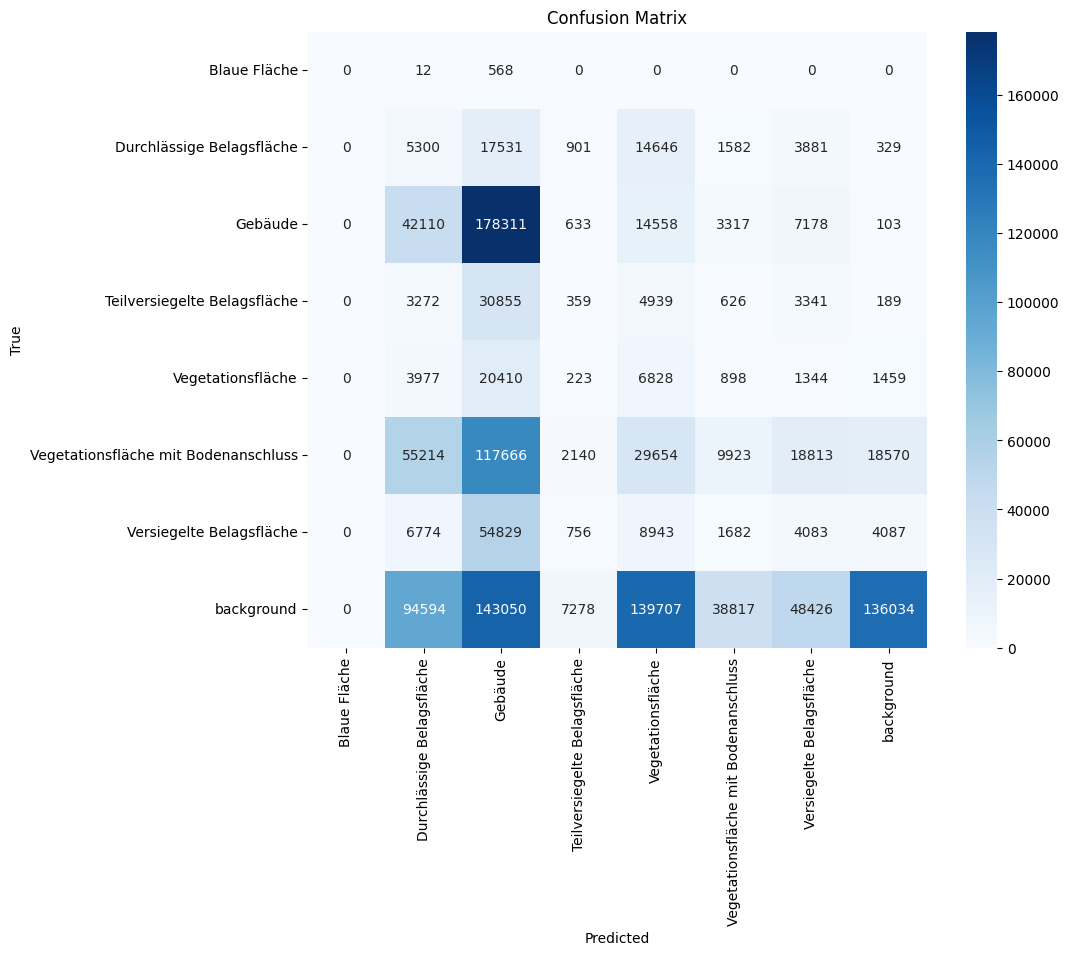

Classification Report:
                                       precision    recall  f1-score   support

                        Blaue Fläche       0.00      0.00      0.00       580
           Durchlässige Belagsfläche       0.03      0.12      0.04     44170
                             Gebäude       0.32      0.72      0.44    246210
        Teilversiegelte Belagsfläche       0.03      0.01      0.01     43581
                   Vegetationsfläche       0.03      0.19      0.05     35139
Vegetationsfläche mit Bodenanschluss       0.17      0.04      0.06    251980
            Versiegelte Belagsfläche       0.05      0.05      0.05     81154
                          background       0.85      0.22      0.35    607906

                            accuracy                           0.26   1310720
                           macro avg       0.18      0.17      0.13   1310720
                        weighted avg       0.49      0.26      0.27   1310720

Class-Specific IoU Scores:
Blaue Fläc

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Dynamische Anpassung der Zielklassen
def get_present_classes(y_true, y_pred, target_classes):
    # Kombiniere y_true und y_pred, um vorhandene Klassen zu identifizieren
    present_classes = set(y_true + y_pred)
    # Filtere nur die Klassen aus target_classes, die tatsächlich vorhanden sind
    filtered_classes = {label: idx for label, idx in target_classes.items() if idx in present_classes}
    return filtered_classes

# Analyse der Validierungsdaten mit dynamischer Anpassung
def analyze_model_performance_dynamic(model, val_dataset, labelmap, num_classes):
    # Zielklassen aus Labelmap
    target_classes = {label: idx for idx, label in enumerate(labelmap.values())}

    y_true, y_pred = [], []

    # Vorhersagen generieren
    for images, masks in val_dataset:
        predictions = model.predict(images)
        y_true.extend(tf.argmax(masks, axis=-1).numpy().flatten())
        y_pred.extend(tf.argmax(predictions, axis=-1).numpy().flatten())

    # Dynamische Zielklassen anpassen
    adjusted_classes = get_present_classes(y_true, y_pred, target_classes)
    adjusted_labels = list(adjusted_classes.values())
    adjusted_names = list(adjusted_classes.keys())

    # Confusion Matrix
    cm = confusion_matrix(
        [y for y in y_true if y in adjusted_labels],
        [y for y in y_pred if y in adjusted_labels],
        labels=adjusted_labels
    )

    # IoU berechnen
    def calculate_class_iou(cm, class_index):
        true_positive = cm[class_index, class_index]
        false_positive = cm[:, class_index].sum() - true_positive
        false_negative = cm[class_index, :].sum() - true_positive
        union = true_positive + false_positive + false_negative
        return true_positive / union if union > 0 else 0

    iou_scores = {}
    for class_name, class_index in adjusted_classes.items():
        iou_scores[class_name] = calculate_class_iou(cm, adjusted_labels.index(class_index))

    # Konfusionsmatrix visualisieren
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=adjusted_names,
        yticklabels=adjusted_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Klassifikationsbericht
    report = classification_report(
        [y for y in y_true if y in adjusted_labels],
        [y for y in y_pred if y in adjusted_labels],
        target_names=adjusted_names,
        zero_division=0
    )
    print("Classification Report:\n", report)

    # IoU-Werte ausgeben
    print("Class-Specific IoU Scores:")
    for class_name, iou in iou_scores.items():
        print(f"{class_name}: {iou:.2f}")

    return cm, iou_scores

# Analyse starten
conf_matrix_dynamic, class_iou_scores_dynamic = analyze_model_performance_dynamic(
    model,
    val_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
    labelmap,
    num_classes
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Unique classes in y_true after removing background: {8, 2, 5}
Unique classes in y_pred after removing background: {8, 2, 5}


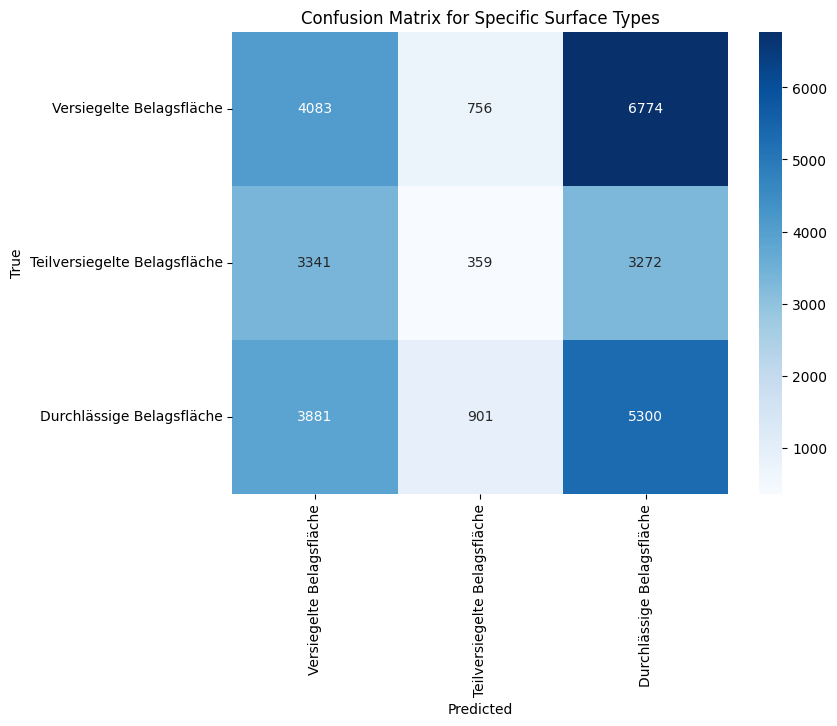

Classification Report for Specific Surface Types:
                               precision    recall  f1-score   support

    Versiegelte Belagsfläche       0.35      0.53      0.42     10082
Teilversiegelte Belagsfläche       0.18      0.05      0.08      6972
   Durchlässige Belagsfläche       0.36      0.35      0.36     11613

                    accuracy                           0.34     28667
                   macro avg       0.29      0.31      0.28     28667
                weighted avg       0.31      0.34      0.31     28667

Class-Specific IoU Scores for Specific Surface Types:
Versiegelte Belagsfläche: 0.22
Teilversiegelte Belagsfläche: 0.04
Durchlässige Belagsfläche: 0.26


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Zielklassen für die drei spezifischen Flächentypen
target_classes_focus = {
    "Versiegelte Belagsfläche": color_to_index[(255, 215, 0)],  # RGB für Versiegelt
    "Teilversiegelte Belagsfläche": color_to_index[(255, 140, 0)],  # RGB für Teilversiegelt
    "Durchlässige Belagsfläche": color_to_index[(184, 134, 11)]  # RGB für Durchlässig
}

# Analyse der spezifischen Klassen mit vollständigem Ausschluss der Hintergrundklasse
def analyze_specific_classes_cleaned(model, val_dataset, target_classes):
    y_true, y_pred = [], []

    # Vorhersagen generieren
    for images, masks in val_dataset:
        predictions = model.predict(images)
        true_classes = tf.argmax(masks, axis=-1).numpy().flatten()
        pred_classes = tf.argmax(predictions, axis=-1).numpy().flatten()

        # Filtere nur Zielklassen aus true_classes und pred_classes
        for t, p in zip(true_classes, pred_classes):
            if t in target_classes.values():
                y_true.append(t)
                y_pred.append(p if p in target_classes.values() else -1)

    # Entferne alle -1 Klassen (Hintergrund) aus y_pred
    y_true_filtered = [y for y, p in zip(y_true, y_pred) if p != -1]
    y_pred_filtered = [p for p in y_pred if p != -1]

    # Debugging: Überprüfen der Klassen nach vollständigem Entfernen
    print("Unique classes in y_true after removing background:", set(y_true_filtered))
    print("Unique classes in y_pred after removing background:", set(y_pred_filtered))

    # Confusion Matrix
    adjusted_labels = list(target_classes.values())
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=adjusted_labels)

    # IoU berechnen
    def calculate_class_iou(cm, class_index):
        true_positive = cm[class_index, class_index]
        false_positive = cm[:, class_index].sum() - true_positive
        false_negative = cm[class_index, :].sum() - true_positive
        union = true_positive + false_positive + false_negative
        return true_positive / union if union > 0 else 0

    iou_scores = {}
    for class_name, class_index in target_classes.items():
        iou_scores[class_name] = calculate_class_iou(cm, adjusted_labels.index(class_index))

    # Konfusionsmatrix visualisieren
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=list(target_classes.keys()),
        yticklabels=list(target_classes.keys())
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for Specific Surface Types")
    plt.show()

    # Klassifikationsbericht
    report = classification_report(
        y_true_filtered,
        y_pred_filtered,
        target_names=list(target_classes.keys()),
        zero_division=0
    )
    print("Classification Report for Specific Surface Types:\n", report)

    # IoU-Werte ausgeben
    print("Class-Specific IoU Scores for Specific Surface Types:")
    for class_name, iou in iou_scores.items():
        print(f"{class_name}: {iou:.2f}")

    return cm, iou_scores

# Analyse starten
conf_matrix_focus_cleaned, class_iou_scores_focus_cleaned = analyze_specific_classes_cleaned(
    model,
    val_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
    target_classes_focus
)


1. Confusion Matrix
Die Confusion Matrix gibt Aufschluss darüber, wie gut das Modell die drei Klassen unterscheidet.

Versiegelte Belagsfläche (True Label: Zeile 1):

Korrekt klassifiziert: 4083 (linke obere Ecke).
Verwechselt mit teilversiegelter Belagsfläche: 756.
Verwechselt mit durchlässiger Belagsfläche: 6774.
Ergebnis: Das Modell hat erhebliche Schwierigkeiten, diese Klasse von durchlässigen Belagsflächen zu unterscheiden.
Teilversiegelte Belagsfläche (True Label: Zeile 2):

Korrekt klassifiziert: 359.
Verwechselt mit versiegelter Belagsfläche: 3341.
Verwechselt mit durchlässiger Belagsfläche: 3272.
Ergebnis: Diese Klasse wird häufig mit den beiden anderen Klassen verwechselt, insbesondere mit der versiegelten Belagsfläche. Die geringe Anzahl an korrekt klassifizierten Pixeln deutet auf Schwierigkeiten bei der Erkennung hin.
Durchlässige Belagsfläche (True Label: Zeile 3):

Korrekt klassifiziert: 5300.
Verwechselt mit versiegelter Belagsfläche: 3881.
Verwechselt mit teilversiegelter Belagsfläche: 901.
Ergebnis: Die durchlässige Belagsfläche wird relativ häufig korrekt klassifiziert, aber es gibt dennoch erhebliche Verwechslungen mit der versiegelten Belagsfläche.
2. Classification Report
Versiegelte Belagsfläche:

Precision (0.35): Nur 35 % der als versiegelt vorhergesagten Flächen sind tatsächlich korrekt.
Recall (0.53): 53 % der tatsächlichen versiegelten Flächen wurden korrekt vorhergesagt.
F1-Score (0.42): Moderates Ergebnis, da Precision und Recall nicht ideal sind.
Teilversiegelte Belagsfläche:

Precision (0.18): Sehr niedrige Genauigkeit, nur 18 % der Vorhersagen für diese Klasse sind korrekt.
Recall (0.05): Nur 5 % der tatsächlichen teilversiegelten Flächen wurden erkannt.
F1-Score (0.08): Extrem schwach, was darauf hinweist, dass das Modell diese Klasse kaum unterscheidet.
Durchlässige Belagsfläche:

Precision (0.36): 36 % der vorhergesagten durchlässigen Flächen sind korrekt.
Recall (0.35): 35 % der tatsächlichen durchlässigen Flächen wurden erkannt.
F1-Score (0.36): Das Modell hat moderate Schwierigkeiten mit dieser Klasse.
Gesamtbewertung (Accuracy: 0.34):

Das Modell klassifiziert nur 34 % der Pixel insgesamt korrekt.
Die macro avg-Werte (Precision: 0.29, Recall: 0.31, F1: 0.28) verdeutlichen die Herausforderungen bei der Unterscheidung der Klassen.
3. IoU-Werte (Intersection over Union)
Versiegelte Belagsfläche (IoU = 0.22):

Nur 22 % der Fläche ist korrekt vorhergesagt.
Es gibt erhebliche Überlappungen mit den anderen Klassen.
Teilversiegelte Belagsfläche (IoU = 0.04):

Fast keine Korrektheit in den Vorhersagen.
Das Modell kann diese Klasse kaum von den anderen unterscheiden.
Durchlässige Belagsfläche (IoU = 0.26):

Die beste Leistung unter den drei Klassen, aber immer noch unzureichend.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


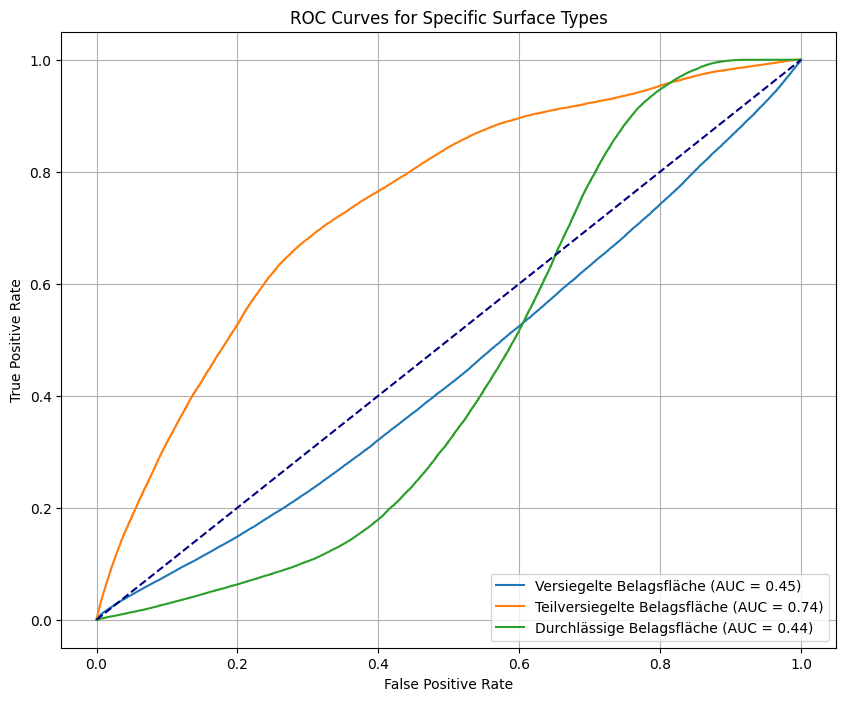

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

def plot_roc_curves(model, val_dataset, target_classes):
    # Zielklassen-Labels
    target_labels = list(target_classes.values())
    class_names = list(target_classes.keys())

    # True Labels und Predictions sammeln
    y_true, y_scores = [], []

    for images, masks in val_dataset:
        predictions = model.predict(images)  # Shape: (batch_size, height, width, num_classes)
        true_classes = tf.argmax(masks, axis=-1).numpy().flatten()  # Shape: (batch_size * height * width)
        pred_probs = predictions.reshape(-1, predictions.shape[-1])  # Shape: (total_pixels, num_classes)

        y_true.extend(true_classes)
        y_scores.extend(pred_probs)

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Binarize true labels for One-vs-All ROC
    y_true_binarized = label_binarize(y_true, classes=target_labels)

    # ROC-Kurven plotten
    plt.figure(figsize=(10, 8))
    for i, class_label in enumerate(target_labels):
        if class_label not in target_labels:
            continue
        # ROC-Kurve für jede Klasse berechnen
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_scores[:, class_label])
        roc_auc = auc(fpr, tpr)

        # Plotten
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    # ROC-Kurven Formatierung
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonale Linie
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Specific Surface Types")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Plot ROC-Kurven für die drei Klassen
plot_roc_curves(
    model,
    val_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
    target_classes_focus
)


Klassen-spezifische Interpretation
Versiegelte Belagsfläche (AUC = 0.45):

Diese Klasse hat eine AUC von 0.45, was unterhalb des Zufallsniveaus liegt.
Dies deutet darauf hin, dass das Modell Schwierigkeiten hat, versiegelte Flächen von anderen Klassen zu unterscheiden.
Mögliche Gründe könnten:
Ähnliche visuelle Eigenschaften zu anderen Klassen.
Mangelnde Repräsentation in den Trainingsdaten.
Suboptimale Features im Modell für diese Klasse.
Teilversiegelte Belagsfläche (AUC = 0.74):

Mit einer AUC von 0.74 zeigt diese Klasse die beste Leistung unter den drei Flächentypen.
Dies bedeutet, dass das Modell relativ gut darin ist, teilversiegelte Flächen zu identifizieren, jedoch noch Verbesserungspotenzial besteht.
Der Unterschied zu den anderen Klassen könnte durch klarere visuelle oder spektrale Merkmale dieser Klasse begründet sein.
Durchlässige Belagsfläche (AUC = 0.44):

Die AUC für diese Klasse liegt bei 0.44, was ebenfalls unterhalb des Zufallsniveaus liegt.
Dies deutet darauf hin, dass das Modell oft fälschlicherweise andere Klassen als durchlässige Flächen vorhersagt.
Ähnlich wie bei den versiegelten Flächen könnte dies auf eine starke Überlappung der Merkmale mit anderen Klassen hindeuten.